# Convolutional Autoencoder

### Initial imports

In [1]:
import warnings

from keras.callbacks import EarlyStopping
from keras.layers import (
    Conv2DTranspose,
    Dense,
    Flatten,
    Input,
    Reshape,
)
from keras.models import Model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from src.experiment.data_loading import (
    compute_temperature,
    load_image_set,
    prepare_train_val_test_splits,
)
from src.experiment.model_blocks import (
    decoder_block,
    encoder_block,
)
from src.experiment.regression_evaluation import (
    regression_evaluation,
)
from src.experiment.visualization import plot_frames

### Loading images

In [2]:
# Dataset dependant parameters
DATA_FOLDER = "data/3ball"
NUM_BALLS = 3
PIXELS_PER_AXIS = 32
COLORED_BALLS = False

X1, X2, Y = load_image_set(data_folder=DATA_FOLDER, colored_balls=COLORED_BALLS)

100%|██████████| 10000/10000 [00:01<00:00, 5373.28it/s]


### Temperature computation and data split

In [3]:
temperature = compute_temperature(data_folder=DATA_FOLDER, num_balls=NUM_BALLS)

# Prepare train, validation, and test splits
(
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    temperature_train,
    temperature_val,
    temperature_test,
) = prepare_train_val_test_splits(X1, X2, Y, temperature)

### Model definition and training

We define both the convolutional autoencoder and the encoder part as two models. We will use the encoder to obtain the bottleneck layers output (encoder output).

In [4]:
# Input layer
input_img = Input(shape=(PIXELS_PER_AXIS, PIXELS_PER_AXIS, 2))

# Encoder layers
x = encoder_block(input_layer=input_img, n_filters=16)
x = encoder_block(input_layer=x, n_filters=64)
encoded = encoder_block(input_layer=x, n_filters=128)

# Bottleneck layer
x = Flatten()(encoded)
encoded_shape = x.shape[1]
encoded_flattened = Reshape((encoded_shape,))(x)

# Encoder model
encoder = Model(input_img, encoded_flattened)

# Decoder layers
x = decoder_block(input_layer=encoded, n_filters=128)
x = decoder_block(input_layer=x, n_filters=64)
x = decoder_block(input_layer=x, n_filters=16)
decoded = Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

model = Model(input_img, decoded, name="CAE")
model.summary()

Model: "CAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0       

In [5]:
model.compile(optimizer="adam", loss="mse")

model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001
        )
    ],
)

Epoch 1/100
250/250 [==============================] - 30s 101ms/step - loss: 0.0596 - val_loss: 0.0215
Epoch 2/100
250/250 [==============================] - 17s 68ms/step - loss: 0.0139 - val_loss: 0.0147
Epoch 3/100
250/250 [==============================] - 25s 101ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 4/100
250/250 [==============================] - 22s 89ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 5/100
250/250 [==============================] - 18s 70ms/step - loss: 0.0097 - val_loss: 0.0107
Epoch 6/100
250/250 [==============================] - 18s 70ms/step - loss: 0.0092 - val_loss: 0.0120
Epoch 7/100
250/250 [==============================] - 27s 107ms/step - loss: 0.0087 - val_loss: 0.0105
Epoch 8/100
250/250 [==============================] - 26s 105ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 9/100
250/250 [==============================] - 28s 112ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 10/100
250/250 [==============================] - 27s 106ms/st

### Model reconstructions

We print (from left to right) the 3 frames of the sample (2 inputs and output), an auxiliar image to see of how much movement there is between the first and final frame, the reconstructed image and the 3rd frame over the reconstructed image. This last image is useful to see if the position of the balls is accurately predicted.

32/32 [==============================] - 1s 31ms/step


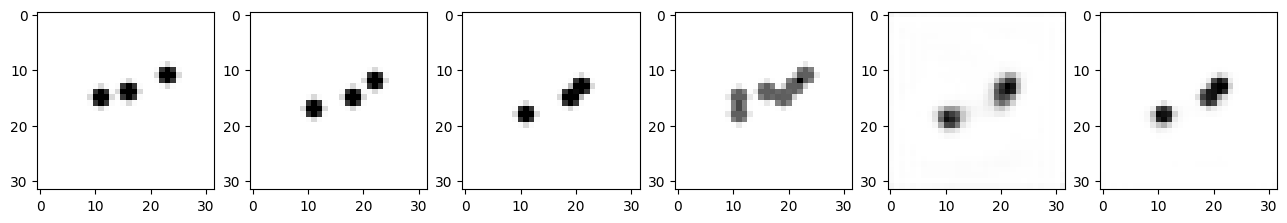

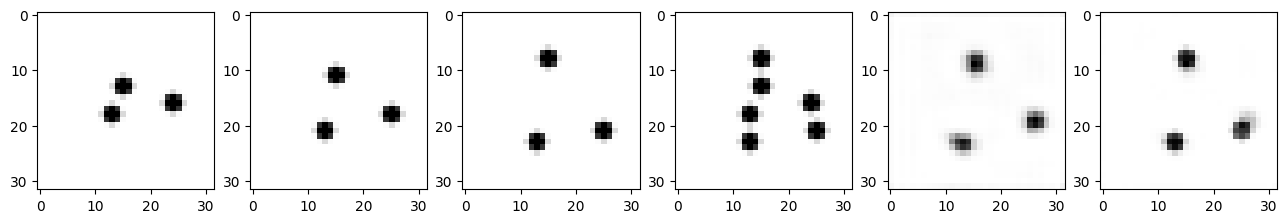

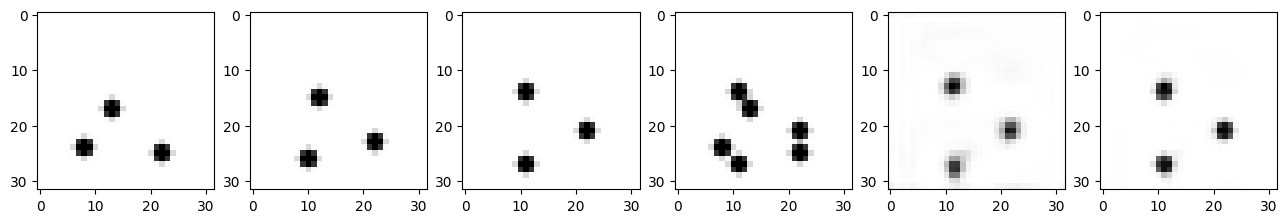

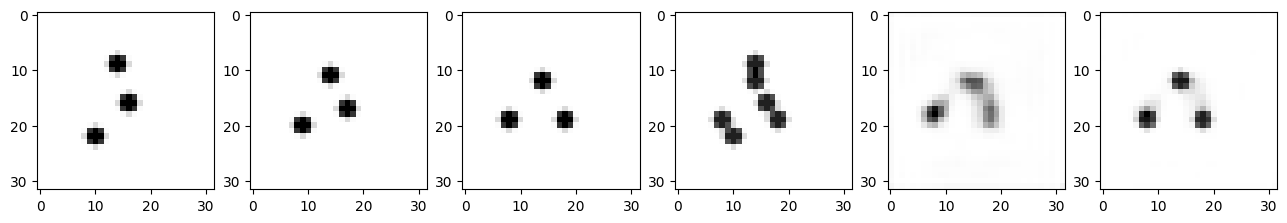

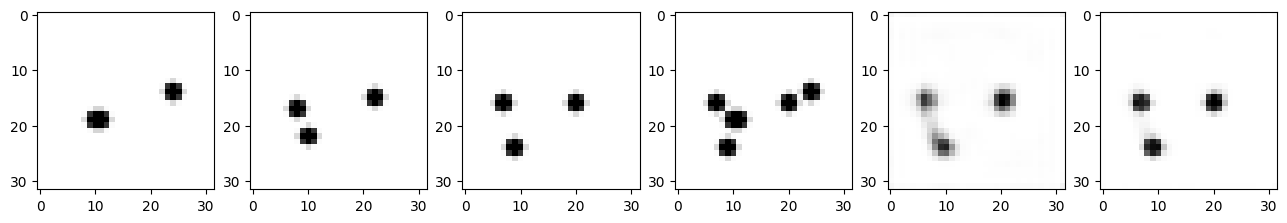

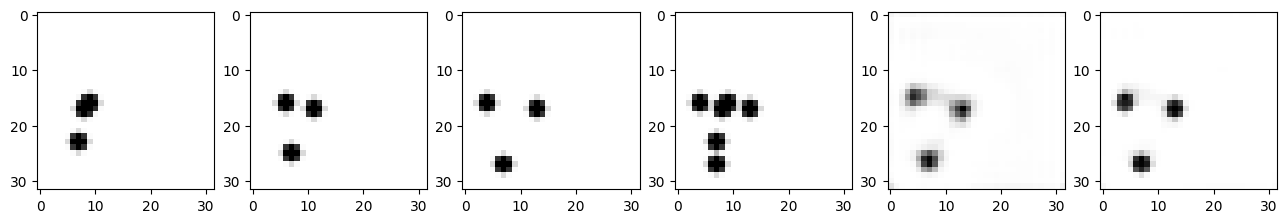

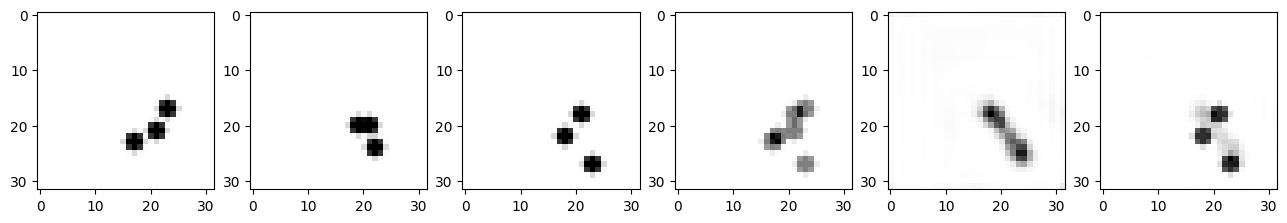

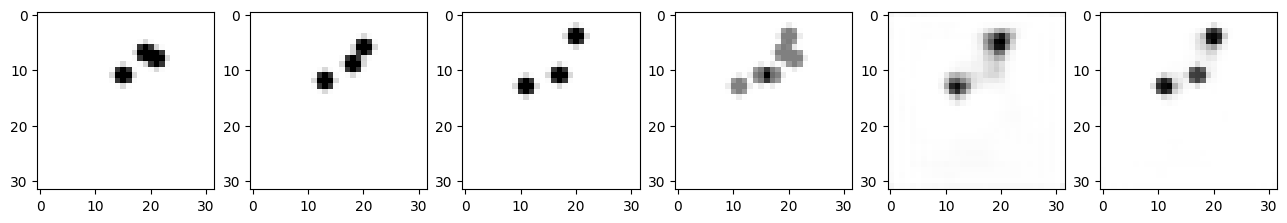

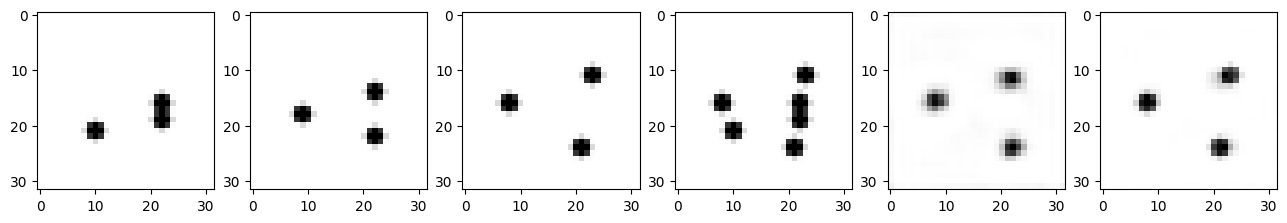

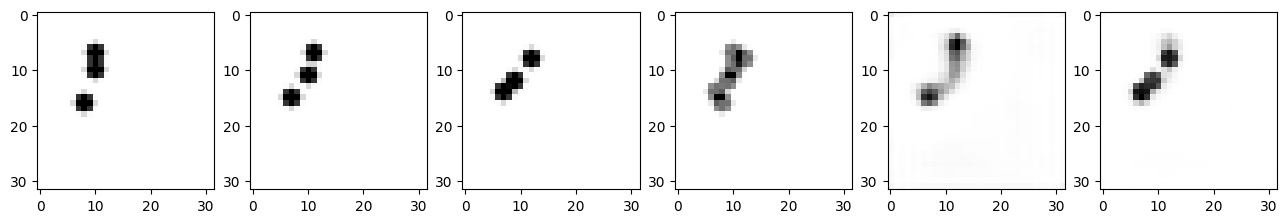

In [6]:
plot_frames(
    model=model,
    x_test=x_test,
    y_test=y_test,
    pixels_per_axis=PIXELS_PER_AXIS,
    colored_balls=COLORED_BALLS,
)

### Temperature regression from encoding of images

We train a neural network and several regressors from Sk-learn to try to regress the temperature of the system by using the encoded representation of the previous model on the test samples.

We want to see if the temperature concept is learnt inside the neural network and we are able to extract it.

In [7]:
# Encoding of the images
encoded_imgs_train = encoder.predict(x_train)
encoded_imgs_val = encoder.predict(x_val)
encoded_imgs_test = encoder.predict(x_test)

input_code = Input(shape=(2048,))
x = Dense(64)(input_code)
x = Dense(2)(x)
final_layer = Dense(1)(x)

# Compile the model
temperature_regressor = Model(input_code, final_layer)
temperature_regressor.compile(optimizer="adam", loss="mse")

# Train the model
temperature_regressor.fit(
    encoded_imgs_train,
    temperature_train,
    epochs=250,
    batch_size=32,
    shuffle=True,
    validation_data=(encoded_imgs_val, temperature_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001
        )
    ],
)

32/32 [==============================] - 1s 15ms/step
Epoch 1/250
250/250 [==============================] - 3s 8ms/step - loss: 2.5587 - val_loss: 0.3377
Epoch 2/250
250/250 [==============================] - 1s 5ms/step - loss: 0.2898 - val_loss: 0.2864
Epoch 3/250
250/250 [==============================] - 1s 4ms/step - loss: 0.2810 - val_loss: 0.2654
Epoch 4/250
250/250 [==============================] - 1s 4ms/step - loss: 0.2279 - val_loss: 0.1407
Epoch 5/250
250/250 [==============================] - 1s 3ms/step - loss: 0.0908 - val_loss: 0.0655
Epoch 6/250
250/250 [==============================] - 1s 4ms/step - loss: 0.0705 - val_loss: 0.0866
Epoch 7/250
250/250 [==============================] - 1s 4ms/step - loss: 0.0578 - val_loss: 0.0723
Epoch 8/250
250/250 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0353
Epoch 9/250
250/250 [==============================] - 1s 3ms/step - loss: 0.0444 - val_loss: 0.0354
Epoch 10/250
250/250 [===============

In [8]:
regression_evaluation(
    regressor_model=temperature_regressor,
    x_test=encoded_imgs_test,
    y_test=temperature_test,
)

32/32 [==============================] - 0s 2ms/step
Sample 0
Prediction: [0.48302573]
True values: 0.3190355937288492
Sample 1
Prediction: [0.5685494]
True values: 0.6863389981249824
Sample 2
Prediction: [0.7044234]
True values: 0.4708567949894071
Sample 3
Prediction: [0.52193147]
True values: 0.5590169943749475
Sample 4
Prediction: [0.57544637]
True values: 0.6083802566454808


No good predictions are produced.

Therefore, we proceed to try with several models from Scikit-learn and XGBoost libraries.

In [9]:
warnings.filterwarnings("ignore")

models = [
    LinearRegression(),
    KNeighborsRegressor(),
    RandomForestRegressor(max_depth=50, random_state=0),
    GradientBoostingRegressor(learning_rate=0.1, random_state=0, max_depth=5),
    XGBRegressor(
        objective="reg:squarederror",
        colsample_bytree=0.3,
        learning_rate=0.1,
        alpha=10,
        n_estimators=10,
    ),
    MLPRegressor(hidden_layer_sizes=(16, 8, 4, 2)),
]

best_model = None
best_score = float("inf")
for model in models:
    model.fit(encoded_imgs_train, temperature_train)
    print(model.__class__.__name__)
    score = mean_squared_error(temperature_val, model.predict(encoded_imgs_val))
    if score < best_score:
        best_score = score
        best_model = model
    print(score)

LinearRegression
0.01037395333351181
KNeighborsRegressor
0.022628554159514605
RandomForestRegressor
0.011802399955439427
GradientBoostingRegressor
0.009683055552230157
XGBRegressor
0.019529179693722025
MLPRegressor
0.03111120126324596


These are the predictions of the best model from the ones trained on the previous cell.

In [10]:
regression_evaluation(
    regressor_model=best_model, x_test=encoded_imgs_test, y_test=temperature_test
)

Sample 0
Prediction: 0.5042714
True values: 0.3190355937288492
Sample 1
Prediction: 0.5042714
True values: 0.6863389981249824
Sample 2
Prediction: 0.5042714
True values: 0.4708567949894071
Sample 3
Prediction: 0.5042714
True values: 0.5590169943749475
Sample 4
Prediction: 0.5042714
True values: 0.6083802566454808


The regressor is just learning to aproximate to the mean temperature value.